# Graphical Analysis of AI Repositories and Contributors

# Table of Contents
- [Introduction](#Introduction)
- [Database Connection](#onnect-to-the-augur-database)
- [Load the URLs of AI repositories](#load-the-urls-of-ai-repositories)
- [Get repo IDs and names](#retrieve-the-repository-ids-and-the-repository-names)
- [Retrieve contributors](#retrieve-different-types-of-contributors-made-to-the-repositories)
  - [PR Contributors](#retrieve-pr-reviewers)
  - [PR Reviewer Contributors](#retrieve-pr-reviewers)
  - [Commit Contributors](#retrieve-commit-contributors)
- [Representing projects and contributors as nodes](#representing-projects-and-contributors-as-nodes)
  - [Functions to create and plot graphs](#below-are-the-functions-which-we-use-often-to-create-a-graph-get-nodes-get-colors-and-plot)
  - [Commit contributor graph](#commit-contributor-graph)
  - [PR contributor graph](#pr-contributor-graph)
  - [PR Reviewer graph](#pull-request-reviewer-contributor-graph)
- [Representing projects as nodes and contributors as edges](#representing-projects-as-nodes-and-edges-as-contributors)
- [Conclusion](#Conclusion)

## Introduction

In this notebook, we programatically view the connections between open source projects, determine project clusters, and map out technology ecosystems. We explore the Augur GitHub data to view relationships between open source projects and communities by studying graphs based on relations such as common contributors and project activities between different AI GitHub repositories.

In [1]:
# Importing the time module
import time

# Getting the current time in seconds since the start and storing it in the variable start_time
start_time = time.time()

In [2]:
# Importing the pandas library for data manipulation and analysis
import pandas as pd

# Importing the collections module for specialized container datatypes
import collections

# Importing the SQLAlchemy library for SQL database toolkit and Object-Relational Mapping (ORM)
import sqlalchemy as salc

# Importing the json module to work with JSON data
import json

# Importing the NetworkX library for creating and analyzing complex networks
import networkx as nx

# Importing the pyplot module from matplotlib for plotting and visualization
import matplotlib.pyplot as plt

# Importing the patches module from matplotlib for creating graphical patches
import matplotlib.patches as mpatches

# Importing specific functions from SQLAlchemy
from sqlalchemy import create_engine, text

## Connect to the Augur database

In [3]:
# Opening the JSON file containing database credentials and loading it into a dictionary
with open("data/il_ai_creds.json") as config_file:
    config = json.load(config_file)
    
# Creating a PostgreSQL database connection string using the credentials from the JSON file
database_connection_string = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(
    config['user'],        # Username
    config['password'],    # Password
    config['host'],        # Hostname
    config['port'],        # Port number
    config['database']     # Database name
)

# Assigning the connection string to a variable
connection_string = database_connection_string

# Creating a SQLAlchemy engine using the connection string
engine = create_engine(connection_string)

## Load the URLs of AI repositories

- There are different verticals like math, nlp, gen_ai, personal_assistants, llm etc
- In this notebook, we are performing our analysis on math repositories as graphicals interpretation will be too messy if we try to plot all at once
- If you want to perform the same analysis on other verticals, just replace math with your choice in data.get('math)
- If you want to perofrm the analysis on all repositories at once, uncomment the cell following the below cell

In [4]:
# Opening the JSON file containing AI repository data and loading it into a dictionary
f = open('ai_repos.json')
data = json.load(f)

# Closing the file after loading the data
f.close()  

# Initializing an empty list to store repository git URLs
repo_git_set = []

# Extracting the list of repositories under the 'math' category from the loaded JSON data
repo_git_set = data.get('math')

In [5]:
# for key in data.keys():
#     repo_git_set.extend(data.get(key))

## Retrieve the repository IDs and the repository names

In [6]:
# Initializing empty lists to store repository IDs and names
repo_set = []
repo_name_set = []

# Iterating through the list of repository git URLs
for repo_git in repo_git_set:
    # Creating a SQL query to fetch repository ID and name for each git URL
    repo_query = text(f"""
                    SET SCHEMA 'augur_data';
                    SELECT 
                        b.repo_id,
                        b.repo_name
                    FROM
                        repo_groups a,
                        repo b
                    WHERE
                        a.repo_group_id = b.repo_group_id AND
                        b.repo_git = '{repo_git}'
            """)

    # Using the connection to execute the query
    with engine.connect() as connection:
        t = connection.execute(repo_query)  # Executing the query
        results = t.mappings().all()  # Fetching all the results
        
        # Checking if results are found and extracting repo_id and repo_name
        if results:
            repo_id = results[0]['repo_id']
            repo_name = results[0]['repo_name']
        else:
            repo_id = None
            repo_name = None
        
        # Appending the fetched repository ID and name to the respective lists
        repo_set.append(repo_id)
        repo_name_set.append(repo_name)

# Printing the lists of repository IDs and names
print(repo_set)
print(repo_name_set)

[25495, 25498, 25497, 25501, 25500, 25504, 25503, 25496, 25502, 25499]
['numpy', 'tensorflow', 'networkx', 'pytorch', 'keras-io', 'tinygrad', 'pandas', 'polaris', 'arrow', 'mlx']


## Retrieve different types of contributors made to the repositories 
- PR Contributors
- PR Review Contributors
- Commit Contributors

### Retrieve PR Contributors

We will now fetch all the PR contributors for various repositories.

In [7]:
# Initializing an empty DataFrame to store pull request contributions
pr_contrib = pd.DataFrame()

# Iterating through the list of repository IDs
for repo_id in repo_set:
    # Skipping if repo_id is None
    if not repo_id:
        continue
    
    # Creating a SQL query to fetch pull request contributions for each repository
    repo_query = salc.sql.text(f"""
                    SET SCHEMA 'augur_data';
                    SELECT 
                        r.repo_id,
                        r.repo_name,
                        r.repo_git,
                        prm.cntrb_id,
                        prm.pull_request_id
                    FROM
                        repo r, pull_request_meta prm
                    WHERE
                        prm.repo_id = '{repo_id}' AND
                        prm.repo_id = r.repo_id
                """)
    
    # Executing the query and reading the results into a DataFrame
    df_current_repo = pd.read_sql(repo_query, con=engine)
    
    # Concatenating the current repository's data with the main DataFrame
    pr_contrib = pd.concat([pr_contrib, df_current_repo])

# Resetting the index of the DataFrame
pr_contrib = pr_contrib.reset_index()

# Dropping the old index column
pr_contrib.drop("index", axis=1, inplace=True)

# Renaming the columns of the DataFrame
pr_contrib.columns = ['repo_id', 'repo_name', 'repo_git', 'cntrb_id', 'pull_request_id']

# Displaying the DataFrame
display(pr_contrib)

# Displaying the data types of the DataFrame columns
pr_contrib.dtypes

,repo_id,repo_name,repo_git,cntrb_id,pull_request_id
0,25495,numpy,https://github.com/numpy/numpy,01006794-c200-0000-0000-000000000000,98752
1,25495,numpy,https://github.com/numpy/numpy,01000466-1400-0000-0000-000000000000,261866
2,25495,numpy,https://github.com/numpy/numpy,01000466-1400-0000-0000-000000000000,264903
3,25495,numpy,https://github.com/numpy/numpy,0100051e-1700-0000-0000-000000000000,265789
4,25495,numpy,https://github.com/numpy/numpy,01000466-1400-0000-0000-000000000000,265789
...,...,...,...,...,...
408979,25499,mlx,https://github.com/ml-explore/mlx,01062118-7200-0000-0000-000000000000,41539
408980,25499,mlx,https://github.com/ml-explore/mlx,01062118-7200-0000-0000-000000000000,41540
408981,25499,mlx,https://github.com/ml-explore/mlx,01062118-7200-0000-0000-000000000000,41540
408982,25499,mlx,https://github.com/ml-explore/mlx,01062118-7200-0000-0000-000000000000,41541


repo_id             int64
repo_name          object
repo_git           object
cntrb_id           object
pull_request_id     int64
dtype: object

### Retrieve PR Reviewers

We will now fetch all the PR Reviewers for various repositories.

In [8]:
# Initialize an empty DataFrame to store combined results
prr_contrib = pd.DataFrame()

# Iterate through each repo_id in repo_set
for repo_id in repo_set:
    # Skip iteration if repo_id is empty or None
    if not repo_id:
        continue
    
    # Construct SQL query to select relevant columns from repo and pull_request_reviews tables
    repo_query = salc.sql.text(f"""
                    SET SCHEMA 'augur_data';  
                    SELECT r.repo_id,
                        r.repo_name,
                        r.repo_git,
                        prr.cntrb_id,
                        prr.pull_request_id
                    FROM
                        repo r, pull_request_reviews prr
                    WHERE
                        prr.repo_id = \'{repo_id}\' AND  
                        prr.repo_id = r.repo_id
                """)
    
    # Execute query and load results into DataFrame
    df_current_repo = pd.read_sql(repo_query, con=engine)
    
    # Concatenate results to prr_contrib DataFrame
    prr_contrib = pd.concat([prr_contrib, df_current_repo])

# Reset index of the DataFrame
pr_contrib = pr_contrib.reset_index()

# Drop the old index column
pr_contrib.drop("index", axis=1, inplace=True)

# Rename columns
prr_contrib.columns =['repo_id', 'repo_name', 'repo_git', 'cntrb_id', 'pull_request_id']

# Display the DataFrame
display(prr_contrib)

# Print the data types of each column
prr_contrib.dtypes

,repo_id,repo_name,repo_git,cntrb_id,pull_request_id
0,25500,keras-io,https://github.com/keras-team/keras-io,0101c0ab-dc00-0000-0000-000000000000,68931
1,25500,keras-io,https://github.com/keras-team/keras-io,01000ad6-6f00-0000-0000-000000000000,68912
2,25500,keras-io,https://github.com/keras-team/keras-io,01000ad6-6f00-0000-0000-000000000000,68911
3,25500,keras-io,https://github.com/keras-team/keras-io,01000ad6-6f00-0000-0000-000000000000,62642
4,25500,keras-io,https://github.com/keras-team/keras-io,01000ad6-6f00-0000-0000-000000000000,62635
...,...,...,...,...,...
2156,25499,mlx,https://github.com/ml-explore/mlx,0100178a-9500-0000-0000-000000000000,41463
2157,25499,mlx,https://github.com/ml-explore/mlx,01008439-5300-0000-0000-000000000000,41391
2158,25499,mlx,https://github.com/ml-explore/mlx,0100178a-9500-0000-0000-000000000000,41324
2159,25499,mlx,https://github.com/ml-explore/mlx,0100178a-9500-0000-0000-000000000000,41250


repo_id            object
repo_name          object
repo_git           object
cntrb_id           object
pull_request_id    object
dtype: object

### Retrieve Commit Contributors

We will now fetch all the Commit contributors for various repositories.

In [9]:
# Initialize an empty DataFrame to store combined results
commit_contrib = pd.DataFrame()

# Iterate through each repo_id in repo_set
for repo_id in repo_set:
    # Skip iteration if repo_id is empty or None
    if not repo_id:
        continue
    
    # Construct SQL query to select relevant columns from repo, commits, and contributors_aliases tables
    repo_query = salc.sql.text(f"""
                    SET SCHEMA 'augur_data'; 
                    SELECT r.repo_id,
                        r.repo_name,
                        r.repo_git,
                        ca.cntrb_id,
                        c.cmt_id
                    FROM
                        repo r, commits c, contributors_aliases ca
                    WHERE
                        c.repo_id = \'{repo_id}\' AND
                        c.repo_id = r.repo_id AND
                        c.cmt_committer_email = ca.alias_email
                """)
    
    # Execute query and load results into DataFrame
    df_current_repo = pd.read_sql(repo_query, con=engine)
    
    # Concatenate results to commit_contrib DataFrame
    commit_contrib = pd.concat([commit_contrib, df_current_repo])

# Reset index of the DataFrame
commit_contrib = commit_contrib.reset_index()

# Drop the old index column
commit_contrib.drop("index", axis=1, inplace=True)

# Rename columns
commit_contrib.columns =['repo_id', 'repo_name', 'repo_git', 'cntrb_id', 'cmt_id']

# Display the DataFrame
display(commit_contrib)

# Print the data types of each column
commit_contrib.dtypes

,repo_id,repo_name,repo_git,cntrb_id,cmt_id
0,25495,numpy,https://github.com/numpy/numpy,01005529-0a00-0000-0000-000000000000,505655
1,25495,numpy,https://github.com/numpy/numpy,01005529-0a00-0000-0000-000000000000,505656
2,25495,numpy,https://github.com/numpy/numpy,01005529-0a00-0000-0000-000000000000,401510
3,25495,numpy,https://github.com/numpy/numpy,01005529-0a00-0000-0000-000000000000,401511
4,25495,numpy,https://github.com/numpy/numpy,01005529-0a00-0000-0000-000000000000,401512
...,...,...,...,...,...
2044272,25499,mlx,https://github.com/ml-explore/mlx,01012f1b-7f00-0000-0000-000000000000,3766970
2044273,25499,mlx,https://github.com/ml-explore/mlx,01012f1b-7f00-0000-0000-000000000000,3766971
2044274,25499,mlx,https://github.com/ml-explore/mlx,01012f1b-7f00-0000-0000-000000000000,3777299
2044275,25499,mlx,https://github.com/ml-explore/mlx,01012f1b-7f00-0000-0000-000000000000,3777300


repo_id       int64
repo_name    object
repo_git     object
cntrb_id     object
cmt_id        int64
dtype: object

Checking if there are any None values for the cntrib_id in the the commit contributors dataframe

In [10]:
commit_contrib['cntrb_id'].isnull().any()

False

## Representing Projects and Contributors as Nodes

In this section, we plot projects and contributors on the same graph as nodes and color them differently to see the relationships between them.

An edge between a contributor(node) and a project(another node) represents that the contributor has worked on or contributed to the project. This kind of relationship is useful for visualizing which contributors are associated with which projects.

### Below are the functions which we use often to create a graph, get nodes, get colors and plot

In [11]:
# Function to create a graph from a DataFrame
def get_graph(df, source, target):
    # Create a graph from the DataFrame's edge list, specifying the source, target, and edge attributes
    G = nx.from_pandas_edgelist(df, 
                                source=source,  # Source column in DataFrame
                                target=target,  # Target column in DataFrame
                                edge_attr='number',  # Edge attribute to include in the graph
                                create_using=nx.MultiGraph())  # Create a MultiGraph (allows multiple edges between nodes)
    return G  # Return the created graph

# Function to get the nodes from the graph
def get_nodes(G):
    # Return the nodes of the graph
    return G.nodes()  

# Function to get colors for nodes based on their type
def get_colors(nodes):
    # Assign colors: 'blue' for repository nodes and 'yellow' for contributor nodes
    colors = ['blue' if n in repo_name_set else 'yellow' for n in nodes]
    # Return the list of colors
    return colors  

# Function to get labels for repository nodes
def get_repo_labels(nodes):
    # Initialize an empty list for repository labels
    repo_labels = []  
    # Iterate through the nodes
    for n in nodes:  
        # Check if the node is a repository
        if n in repo_name_set:  
            # Add repository node to the list of labels
            repo_labels.append(n)  
    # Return the list of repository labels
    return repo_labels  

# Function to plot the graph
def plot(G, colors, repo_labels):
    # Create a plot with specified size
    fig, ax = plt.subplots(figsize=(20, 20))  
    # Create legend patches for contributors and repositories
    yellow_patch = mpatches.Patch(color='yellow', label='Contributor')
    blue_patch = mpatches.Patch(color='blue', label='Repository')
    # Add legend to the plot
    ax.legend(handles=[yellow_patch, blue_patch])  
    # Draw the graph with specified node colors and labels
    nx.draw_networkx(G, node_color=colors, font_size=8, ax=ax, labels={node: node for node in repo_labels})


### Commit Contributor Graph

In this section, we will analyse commit contributors and plot the contributions made to the repositories

In the dataframe, each row represents a repository name and each column represents a contributor. The dataframe contains counts for the number of times a contributor has made contributions to a particular repository. In the dataframe below `df_commit`, each contribution represents a commit. A value 0 means that a particular contributor has made no commits to the repository, and a number `x` means that the contributor has made `x number of commits to the repository.

In [12]:
# Group by 'repo_name' and 'cntrb_id', count occurrences, and reshape with 'repo_name' as columns
df_commit = commit_contrib.groupby(['repo_name', 'cntrb_id']).size().unstack(fill_value=0)

In [13]:
df_commit.head()

cntrb_id,01000002-5600-0000-0000-000000000000,01000004-ca00-0000-0000-000000000000,01000006-8000-0000-0000-000000000000,01000007-8900-0000-0000-000000000000,01000009-0900-0000-0000-000000000000,01000009-ae00-0000-0000-000000000000,0100000a-5400-0000-0000-000000000000,0100000a-ae00-0000-0000-000000000000,0100000f-7700-0000-0000-000000000000,01000010-bb00-0000-0000-000000000000,...,0108a5b7-ff00-0000-0000-000000000000,0108a6f1-9e00-0000-0000-000000000000,0108c567-ba00-0000-0000-000000000000,0108eb97-de00-0000-0000-000000000000,01091e7c-1b00-0000-0000-000000000000,0109ff1f-4600-0000-0000-000000000000,010a209b-dc00-0000-0000-000000000000,010a36e9-1e00-0000-0000-000000000000,010a42c5-1000-0000-0000-000000000000,010a45e6-4c00-0000-0000-000000000000
repo_name,,,,,,,,,,,,,,,,,,,,,
arrow,0,0,0,0,0,0,0,0,26,0,...,0,0,0,0,0,0,0,0,0,0
keras-io,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
mlx,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
networkx,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
numpy,0,0,0,1,0,0,0,0,0,0,...,0,0,5,0,3,0,1,0,0,0


When we use groupby and unstack, the resulting DataFrame has a multi-level index, where the original index values become part of the columns. Resetting the index flattens the DataFrame, making it easier to work with in subsequent operations.

In [14]:
# Reset the index of df_commit to turn 'repo_name' into a column
df_commit = df_commit.reset_index()

In [15]:
df_commit.head()

cntrb_id,repo_name,01000002-5600-0000-0000-000000000000,01000004-ca00-0000-0000-000000000000,01000006-8000-0000-0000-000000000000,01000007-8900-0000-0000-000000000000,01000009-0900-0000-0000-000000000000,01000009-ae00-0000-0000-000000000000,0100000a-5400-0000-0000-000000000000,0100000a-ae00-0000-0000-000000000000,0100000f-7700-0000-0000-000000000000,...,0108a5b7-ff00-0000-0000-000000000000,0108a6f1-9e00-0000-0000-000000000000,0108c567-ba00-0000-0000-000000000000,0108eb97-de00-0000-0000-000000000000,01091e7c-1b00-0000-0000-000000000000,0109ff1f-4600-0000-0000-000000000000,010a209b-dc00-0000-0000-000000000000,010a36e9-1e00-0000-0000-000000000000,010a42c5-1000-0000-0000-000000000000,010a45e6-4c00-0000-0000-000000000000
0,arrow,0,0,0,0,0,0,0,0,26,...,0,0,0,0,0,0,0,0,0,0
1,keras-io,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,mlx,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,networkx,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,numpy,0,0,0,1,0,0,0,0,0,...,0,0,5,0,3,0,1,0,0,0


In `df_melted_commit` we transpose the contributor IDs. Each row is a combination of a unique repository and a unique contributor and the number represents the number of times the contributor has made contributors to the particular repository.

Apply melt function to reshape the DataFrame. In wide format, we have multiple columns representing different contributors. Melting the DataFrame converts these columns into a single column, `cntrb_id` , making the DataFrame longer and narrower.

In [16]:
# Melt df_commit from wide to long format, using 'repo_name' as the identifier variable
df_melted_commit = df_commit.melt(
    id_vars=['repo_name'],  # Columns to keep as identifier variables
    var_name='cntrb_id',    # Name for the variable column
    value_name='number'     # Name for the values column
)

In [17]:
df_melted_commit.head()

,repo_name,cntrb_id,number
0,arrow,01000002-5600-0000-0000-000000000000,0
1,keras-io,01000002-5600-0000-0000-000000000000,0
2,mlx,01000002-5600-0000-0000-000000000000,0
3,networkx,01000002-5600-0000-0000-000000000000,0
4,numpy,01000002-5600-0000-0000-000000000000,0


In [18]:
# Filter df_melted_commit to keep only rows where the 'number' column is not equal to 0
df_melted_commit = df_melted_commit[df_melted_commit[df_melted_commit.columns[2]] != 0]

The resultant dataframe after filtering and keeping only the rows where the value in the third column i.e., number of contributions count (`number`) is not equal to 0

In [19]:
df_melted_commit.head()

,repo_name,cntrb_id,number
8,tensorflow,01000002-5600-0000-0000-000000000000,1
13,networkx,01000004-ca00-0000-0000-000000000000,1
28,tensorflow,01000006-8000-0000-0000-000000000000,1
34,numpy,01000007-8900-0000-0000-000000000000,1
48,tensorflow,01000009-0900-0000-0000-000000000000,12


Create and plot the commit contributor graph

What we see below is a certain set of repositories and their contributors plotted on the same graph. The blue dots represent project repositories and the yellow dots represent their contributors. 

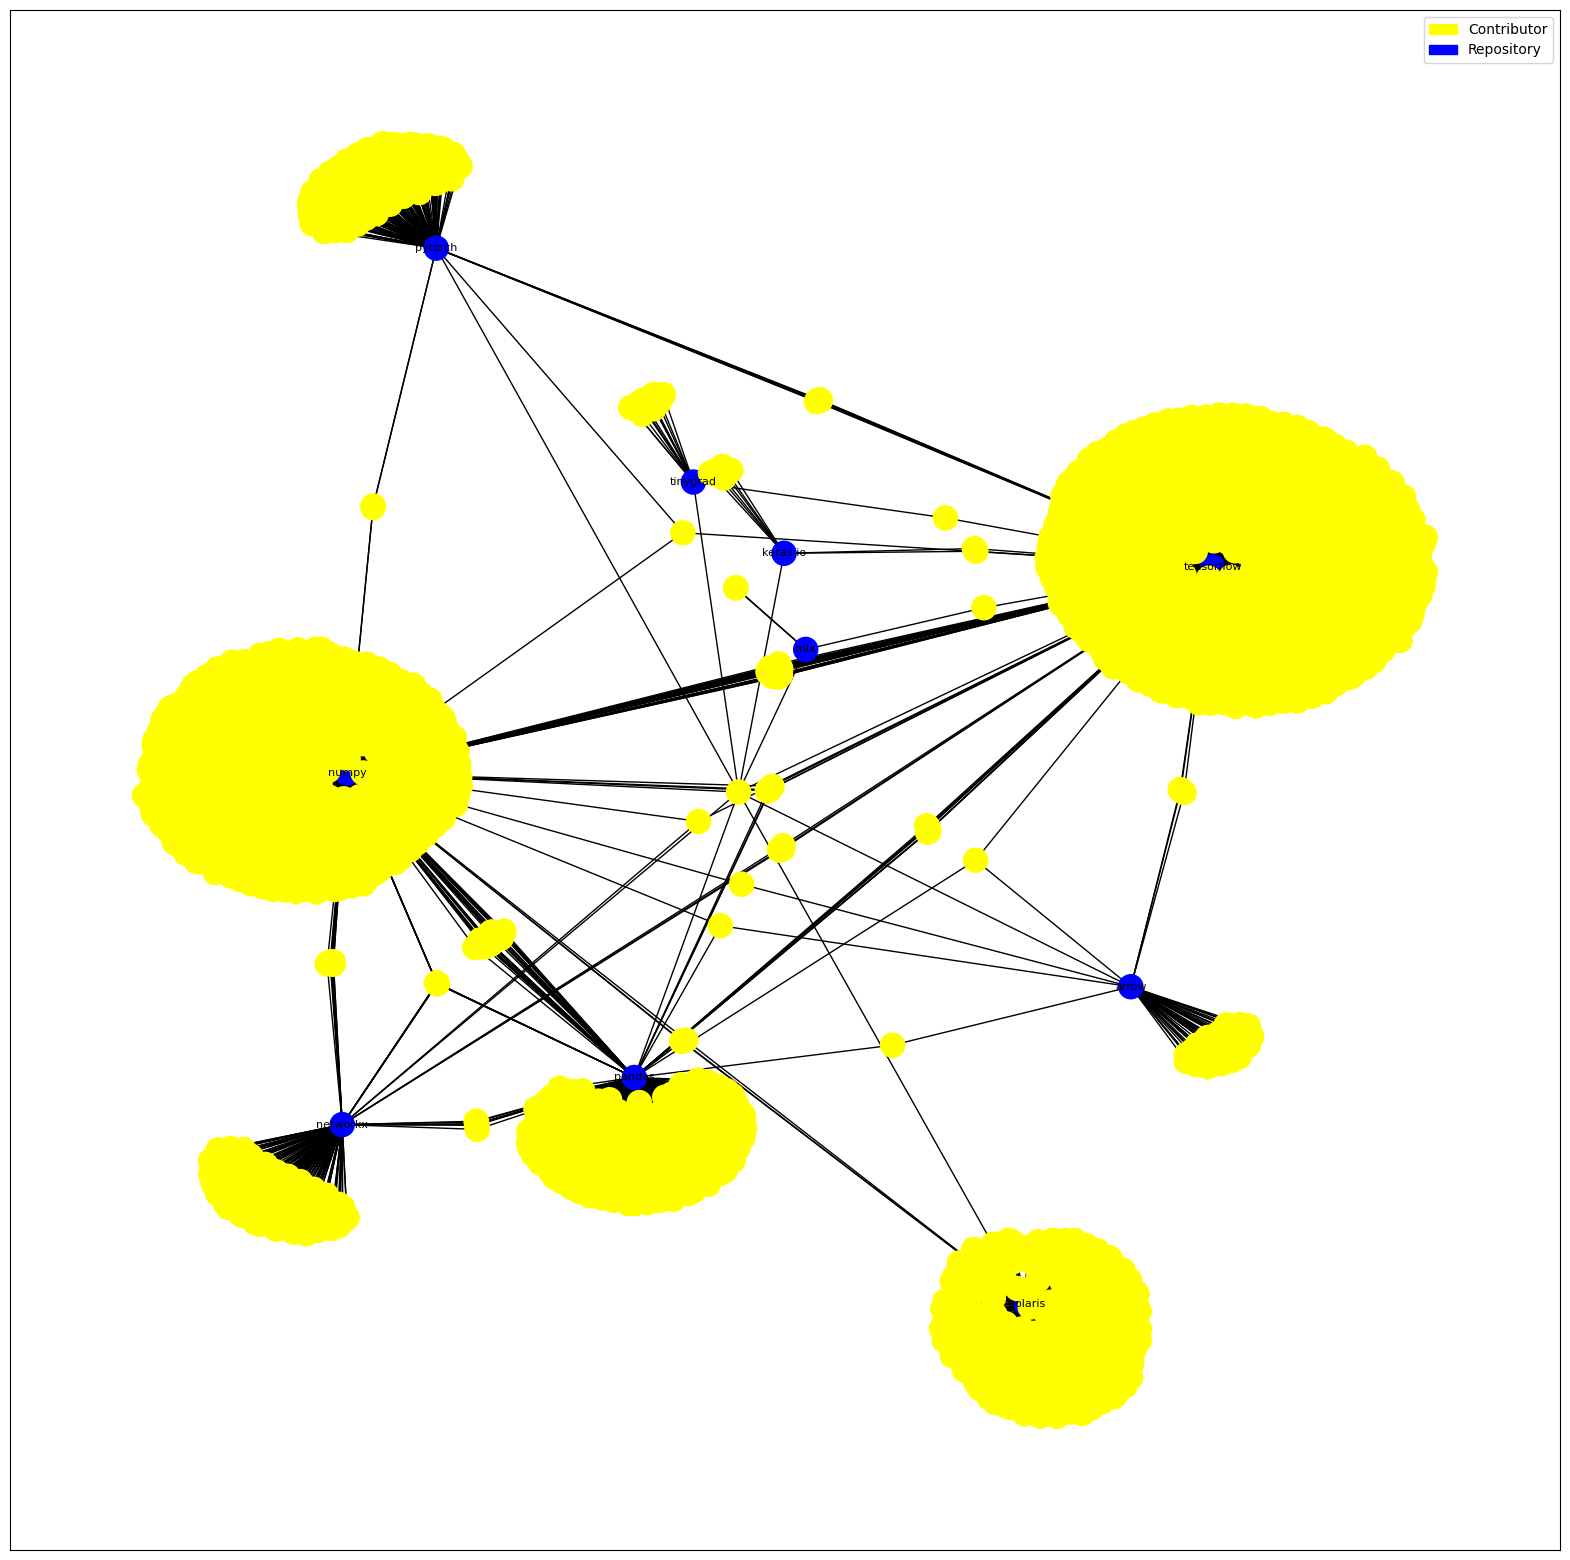

In [20]:
G = get_graph(df_melted_commit, source="repo_name", target='cntrb_id')
nodes = get_nodes(G)
colors = get_colors(nodes)
repo_labels = get_repo_labels(nodes)
plot(G, colors, repo_labels)

#### Weighting the Number of Commits
The number of commits is included in the total_commits column. This information to weight the contributions if needed. For example, you might prioritize contributors not only by the number of repositories they contributed to but also by the total number of commits.

To add weighting, we could rank contributors by a combination of these metrics or create a scoring system in future that considers both the number of repositories and the total commits.

In [21]:
# Group by contributor and count unique repositories
repo_count = df_melted_commit.groupby('cntrb_id')['repo_name'].nunique().reset_index()
repo_count.columns = ['cntrb_id', 'repo_count']

# Group by contributor and sum the number of commits
commit_count = df_melted_commit.groupby('cntrb_id')['number'].sum().reset_index()
commit_count.columns = ['cntrb_id', 'total_commits']

# Merge the two results
combined_df = pd.merge(repo_count, commit_count, on='cntrb_id')

In [22]:
# Filter contributors with connections to 3 or more repositories
top_contributors = combined_df[combined_df['repo_count'] >= 3]

# Get list of repositories each top contributor has contributed to
contributor_repos = df_melted_commit[df_melted_commit['cntrb_id'].isin(top_contributors['cntrb_id'])]

# Group by contributor to list all repositories they contributed to
contributor_repos_list = contributor_repos.groupby('cntrb_id')['repo_name'].apply(list).reset_index()
contributor_repos_list.columns = ['cntrb_id', 'repo_names']

# Merge this list with the top contributors DataFrame
top_contributors_with_repos = pd.merge(top_contributors, contributor_repos_list, on='cntrb_id')

# Display the top contributors and the repositories
display(top_contributors_with_repos)

,cntrb_id,repo_count,total_commits,repo_names
0,010000c7-7300-0000-0000-000000000000,3,99,"[numpy, pandas, tensorflow]"
1,01000108-1c00-0000-0000-000000000000,3,120,"[networkx, numpy, pandas]"
2,0100015b-e500-0000-0000-000000000000,3,22,"[numpy, pandas, tensorflow]"
3,0100021b-4c00-0000-0000-000000000000,3,11,"[networkx, numpy, tensorflow]"
4,0100030c-8500-0000-0000-000000000000,3,86,"[networkx, numpy, pandas]"
5,01000497-2200-0000-0000-000000000000,3,27,"[networkx, numpy, pandas]"
6,010004f9-7500-0000-0000-000000000000,3,539,"[networkx, numpy, pandas]"
7,01000660-bd00-0000-0000-000000000000,3,3205,"[arrow, pandas, tensorflow]"
8,01000bed-5b00-0000-0000-000000000000,3,12,"[networkx, numpy, pandas]"
9,01000f92-5000-0000-0000-000000000000,3,9675,"[arrow, numpy, pandas]"


This gives us an idea of central projects which have a large number of contributors and how other projects are connected to them. However, just given the number of repositories, this graph is hard to dig into, so lets subset this graph to create a smaller plot.

In [23]:
#subsetting the first 50 repo nodes for a smaller plot
smaller_df_melted_commit = df_melted_commit[0:50]

Here, we narrow down the entire set of nodes into view only 50 nodes plotted on a graph. Note, this is just for visual simplicilty. This is not a logical filtering and not all contributors for a project are going to be seen on the same plot

Create and plot the commit contributor graph for a smaller subset

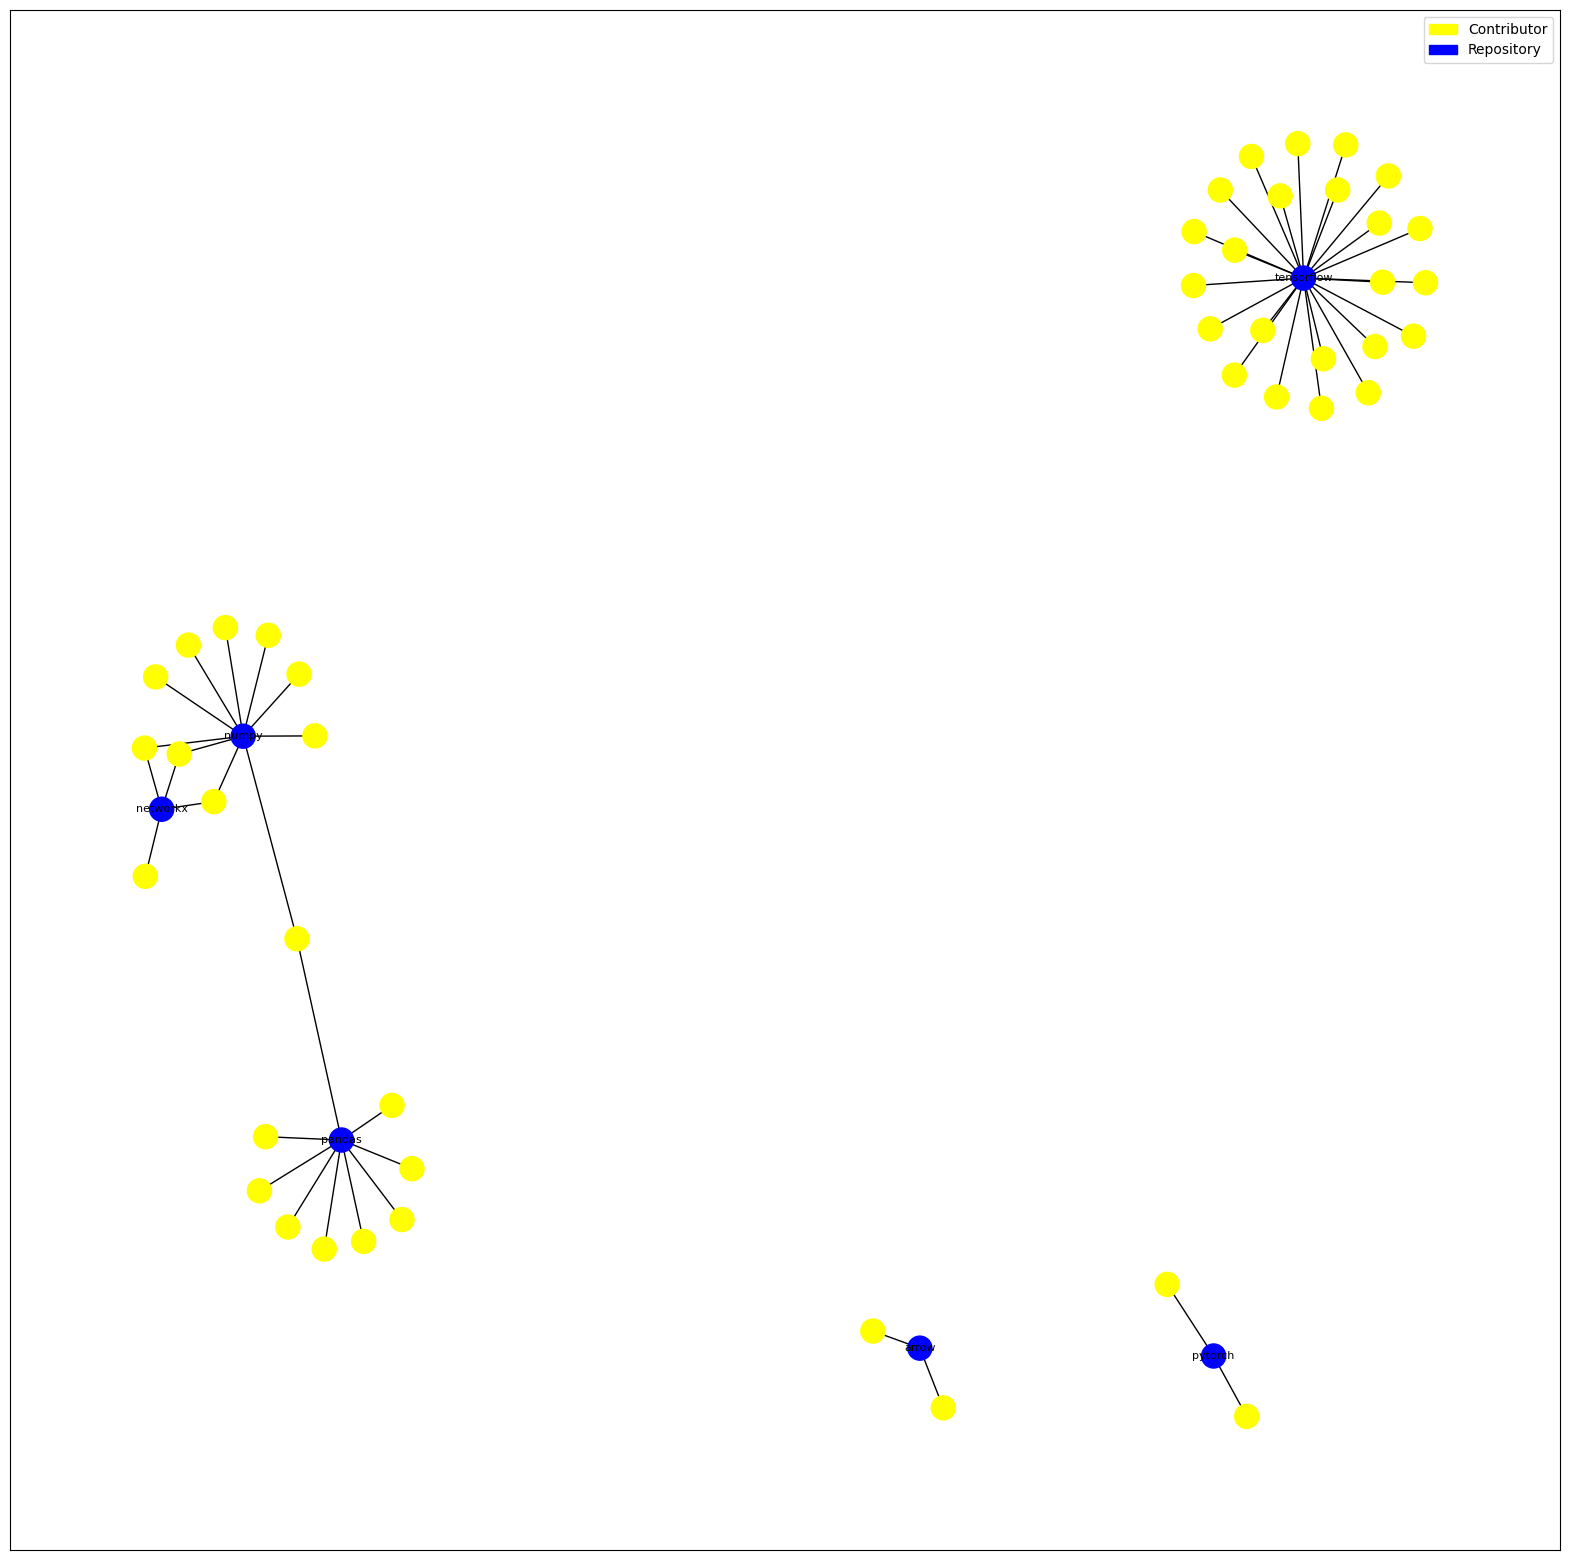

In [24]:
G = get_graph(smaller_df_melted_commit, source="repo_name", target='cntrb_id')
nodes = get_nodes(G)
colors = get_colors(nodes)
repo_labels = get_repo_labels(nodes)
plot(G, colors, repo_labels)

### PR Contributor Graph

In this section, we will analyse pull request contributors and plot the contributions made to the repositories

In the dataframe, each row represents a repository name and each column represents a contributor. The dataframe contains counts for the number of times a contributor has made contributions to a particular repository. In the dataframe below `pr_contrib`, each contribution represents a PR contribution. A value 0 means that a particular contributor has made no PR contributions to the repository, and a number `x` means that the contributor has made `x` number of PR contributions to the repository.

In [25]:
# Group by 'repo_name' and 'cntrb_id', count occurrences, and reshape with 'repo_name' as columns
df_pr = pr_contrib.groupby(['repo_name', 'cntrb_id']).size().unstack(fill_value=0)

In [26]:
# Display the PR dataframe
df_pr.head()

cntrb_id,01000000-5000-0000-0000-000000000000,01000002-3300-0000-0000-000000000000,01000002-5600-0000-0000-000000000000,01000002-8100-0000-0000-000000000000,01000004-6200-0000-0000-000000000000,01000004-c700-0000-0000-000000000000,01000004-ca00-0000-0000-000000000000,01000004-e100-0000-0000-000000000000,01000005-2200-0000-0000-000000000000,01000006-8000-0000-0000-000000000000,...,010a5309-be00-0000-0000-000000000000,010a575b-dd00-0000-0000-000000000000,010a5a96-3d00-0000-0000-000000000000,010a5f5c-ab00-0000-0000-000000000000,010a65e1-0a00-0000-0000-000000000000,010a6612-2d00-0000-0000-000000000000,010a7247-3d00-0000-0000-000000000000,010a7473-6500-0000-0000-000000000000,010a747f-ae00-0000-0000-000000000000,010a79ef-4700-0000-0000-000000000000
repo_name,,,,,,,,,,,,,,,,,,,,,
arrow,0,53,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
keras-io,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
mlx,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
networkx,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
numpy,0,0,0,0,0,0,0,1,0,0,...,0,2,0,0,1,0,0,1,1,0


When we use groupby and unstack, the resulting DataFrame has a multi-level index, where the original index values become part of the columns. Resetting the index flattens the DataFrame, making it easier to work with in subsequent operations.

In [27]:
df_pr = df_pr.reset_index()

Apply melt function to reshape the DataFrame. In wide format, we have multiple columns representing different contributors. Melting the DataFrame converts these columns into a single column, `cntrb_id` , making the DataFrame longer and narrower.

In [28]:
# Melt df_pr from wide to long format, using 'repo_name' as the identifier variable
df_melted_pr = df_pr.melt(
    ['repo_name'],        # Columns to keep as identifier variables
    var_name='cntrb_id',  # Name for the variable column
    value_name='number'   # Name for the values column
)

In [29]:
# Filter df_melted_commit to keep only rows where the 'number' column is not equal to 0
df_melted_pr = df_melted_pr[df_melted_pr[df_melted_pr.columns[2]] != 0]

The resultant dataframe after filtering and keeping only the rows where the value in the third column i.e., number of contributions count (`number`) is not equal to 0

In [30]:
df_melted_pr.head()

,repo_name,cntrb_id,number
8,tensorflow,01000000-5000-0000-0000-000000000000,3
10,arrow,01000002-3300-0000-0000-000000000000,53
28,tensorflow,01000002-5600-0000-0000-000000000000,3
35,pandas,01000002-8100-0000-0000-000000000000,2
48,tensorflow,01000004-6200-0000-0000-000000000000,1


Create and plot the Pull Request contributor graph

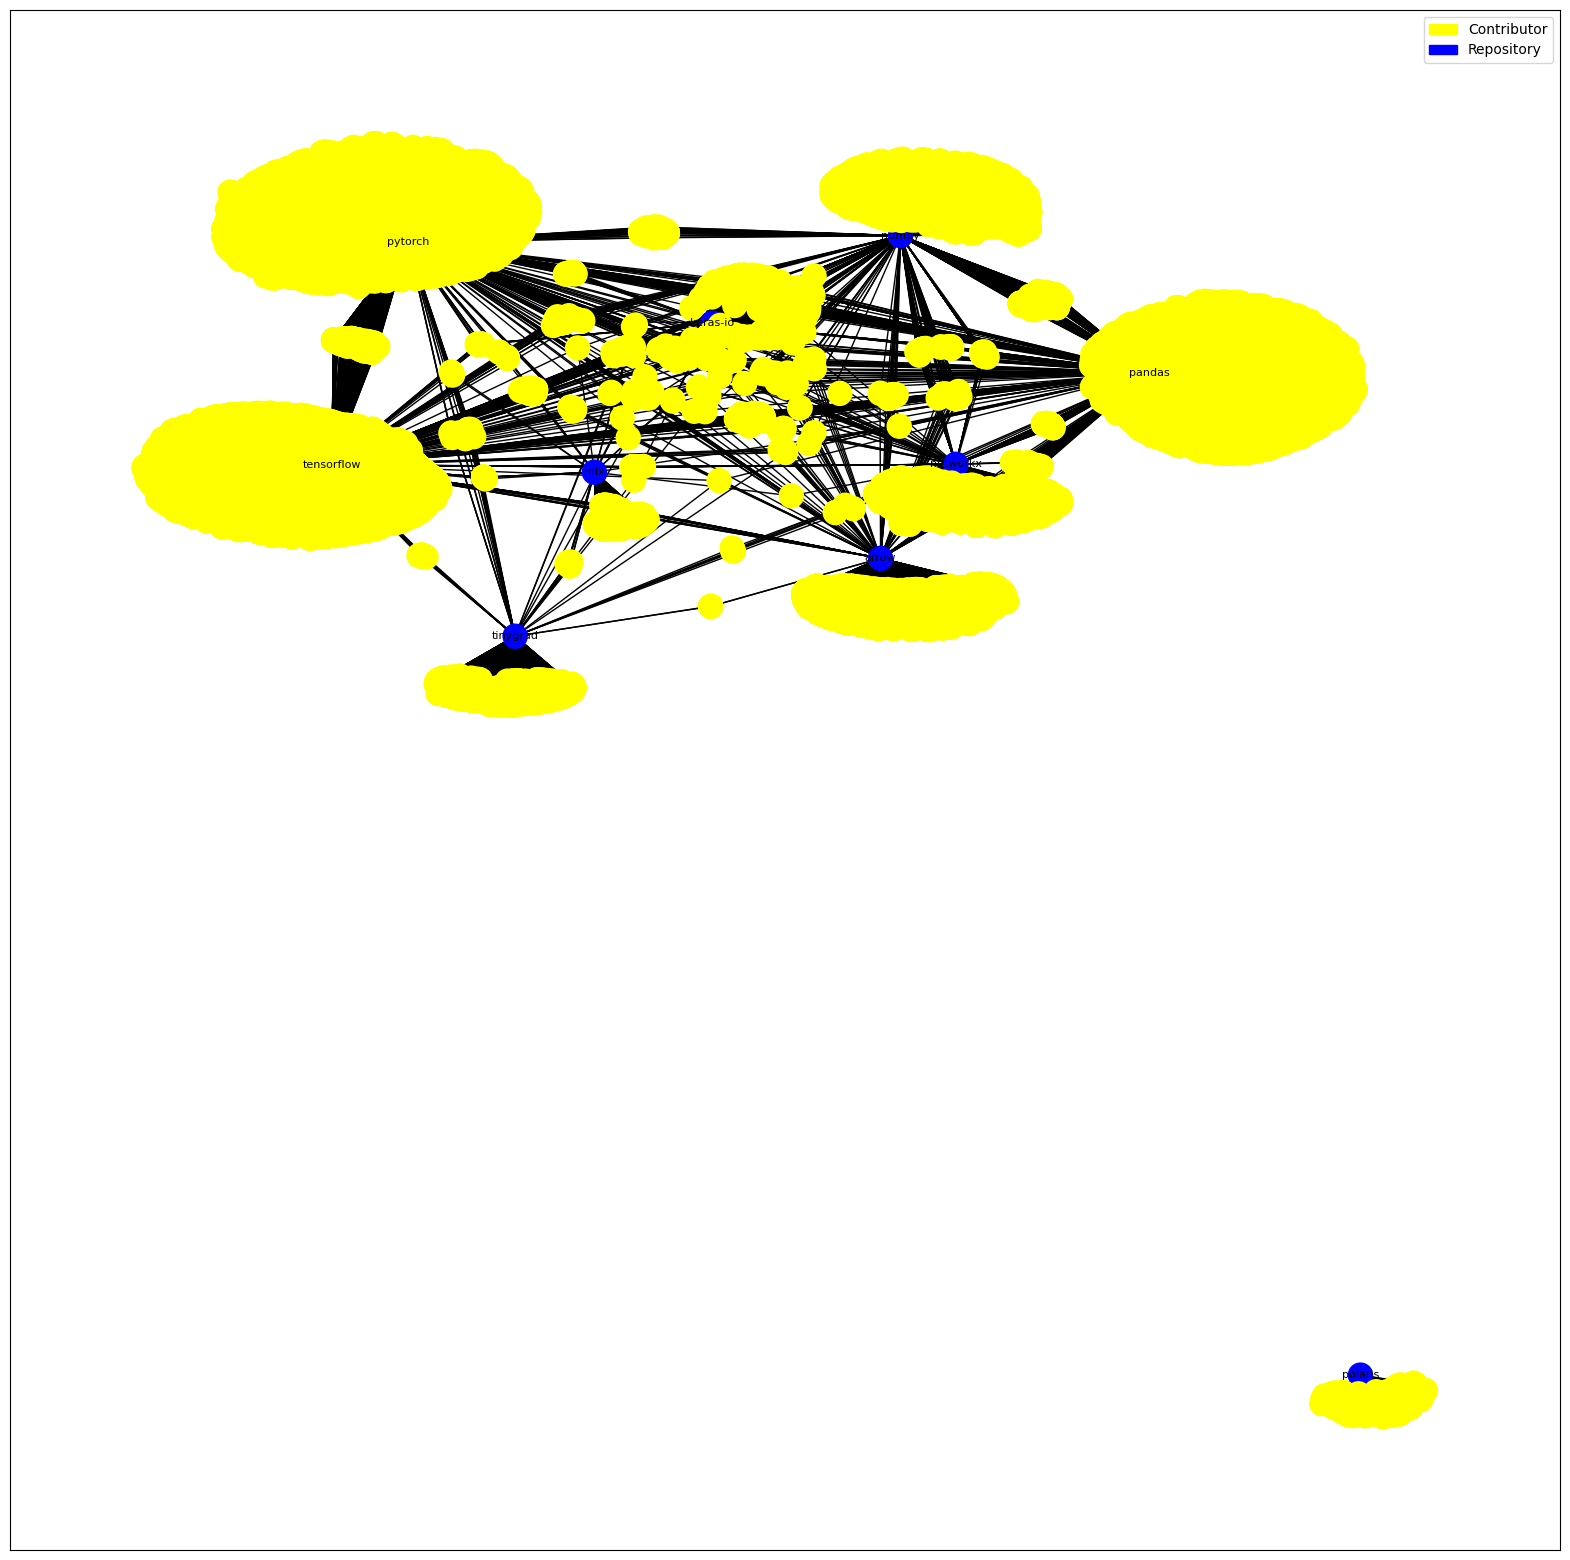

In [31]:
G = get_graph(df_melted_pr, source="repo_name", target='cntrb_id')
nodes = get_nodes(G)
colors = get_colors(nodes)
repo_labels = get_repo_labels(nodes)
plot(G, colors, repo_labels)

### Pull Request Reviewer Contributor graph

In this section, we will analyse pull request reviewer contributors and plot the contributions made to the repositories

In [32]:
# Group by 'repo_name' and 'cntrb_id', count occurrences, and reshape with 'repo_name' as columns
df_prr = prr_contrib.groupby(['repo_name', 'cntrb_id']).size().unstack(fill_value=0)

df_prr.head()

cntrb_id,0100004b-ed00-0000-0000-000000000000,01000054-2d00-0000-0000-000000000000,0100007b-7300-0000-0000-000000000000,010000a8-2b00-0000-0000-000000000000,010000cc-db00-0000-0000-000000000000,01000209-0f00-0000-0000-000000000000,0100023d-d500-0000-0000-000000000000,010002a9-e100-0000-0000-000000000000,010002ee-1e00-0000-0000-000000000000,01000477-6800-0000-0000-000000000000,...,010627eb-a600-0000-0000-000000000000,01065fd0-6d00-0000-0000-000000000000,01068af4-fe00-0000-0000-000000000000,0106aadf-9f00-0000-0000-000000000000,0106c734-bd00-0000-0000-000000000000,0106eafc-3a00-0000-0000-000000000000,0107163a-8900-0000-0000-000000000000,01085cb2-9600-0000-0000-000000000000,01094ec3-8f00-0000-0000-000000000000,01099b6f-be00-0000-0000-000000000000
repo_name,,,,,,,,,,,,,,,,,,,,,
keras-io,0,11,0,1,44,0,0,2,0,0,...,8,3,0,1,4,11,3,0,0,0
mlx,5,0,3,0,0,2,2,0,17,12,...,0,0,6,0,0,0,0,1,8,1


When you use groupby and unstack, the resulting DataFrame has a multi-level index, where the original index values become part of the columns. Resetting the index flattens the DataFrame, making it easier to work with in subsequent operations.

In [33]:
df_prr = df_prr.reset_index()

Apply melt function to reshape the DataFrame. In wide format, we have multiple columns representing different contributors. Melting the DataFrame converts these columns into a single column, `cntrb_id` , making the DataFrame longer and narrower.

In [34]:
# Melt df_prr from wide to long format, using 'repo_name' as the identifier variable
df_melted_prr = df_prr.melt(
    ['repo_name'],        # Columns to keep as identifier variables
    var_name='cntrb_id',  # Name for the variable column
    value_name='number'   # Name for the values column
)

In [35]:
# Filter df_melted_commit to keep only rows where the 'number' column is not equal to 0
df_melted_prr = df_melted_prr[df_melted_prr[df_melted_prr.columns[2]] != 0]

The resultant dataframe after filtering and keeping only the rows where the value in the third column i.e., number of contributions count (`number`) is not equal to 0

In [36]:
df_melted_prr.head()

,repo_name,cntrb_id,number
1,mlx,0100004b-ed00-0000-0000-000000000000,5
2,keras-io,01000054-2d00-0000-0000-000000000000,11
5,mlx,0100007b-7300-0000-0000-000000000000,3
6,keras-io,010000a8-2b00-0000-0000-000000000000,1
8,keras-io,010000cc-db00-0000-0000-000000000000,44


Create and plot the Pull Request Reviewer graph

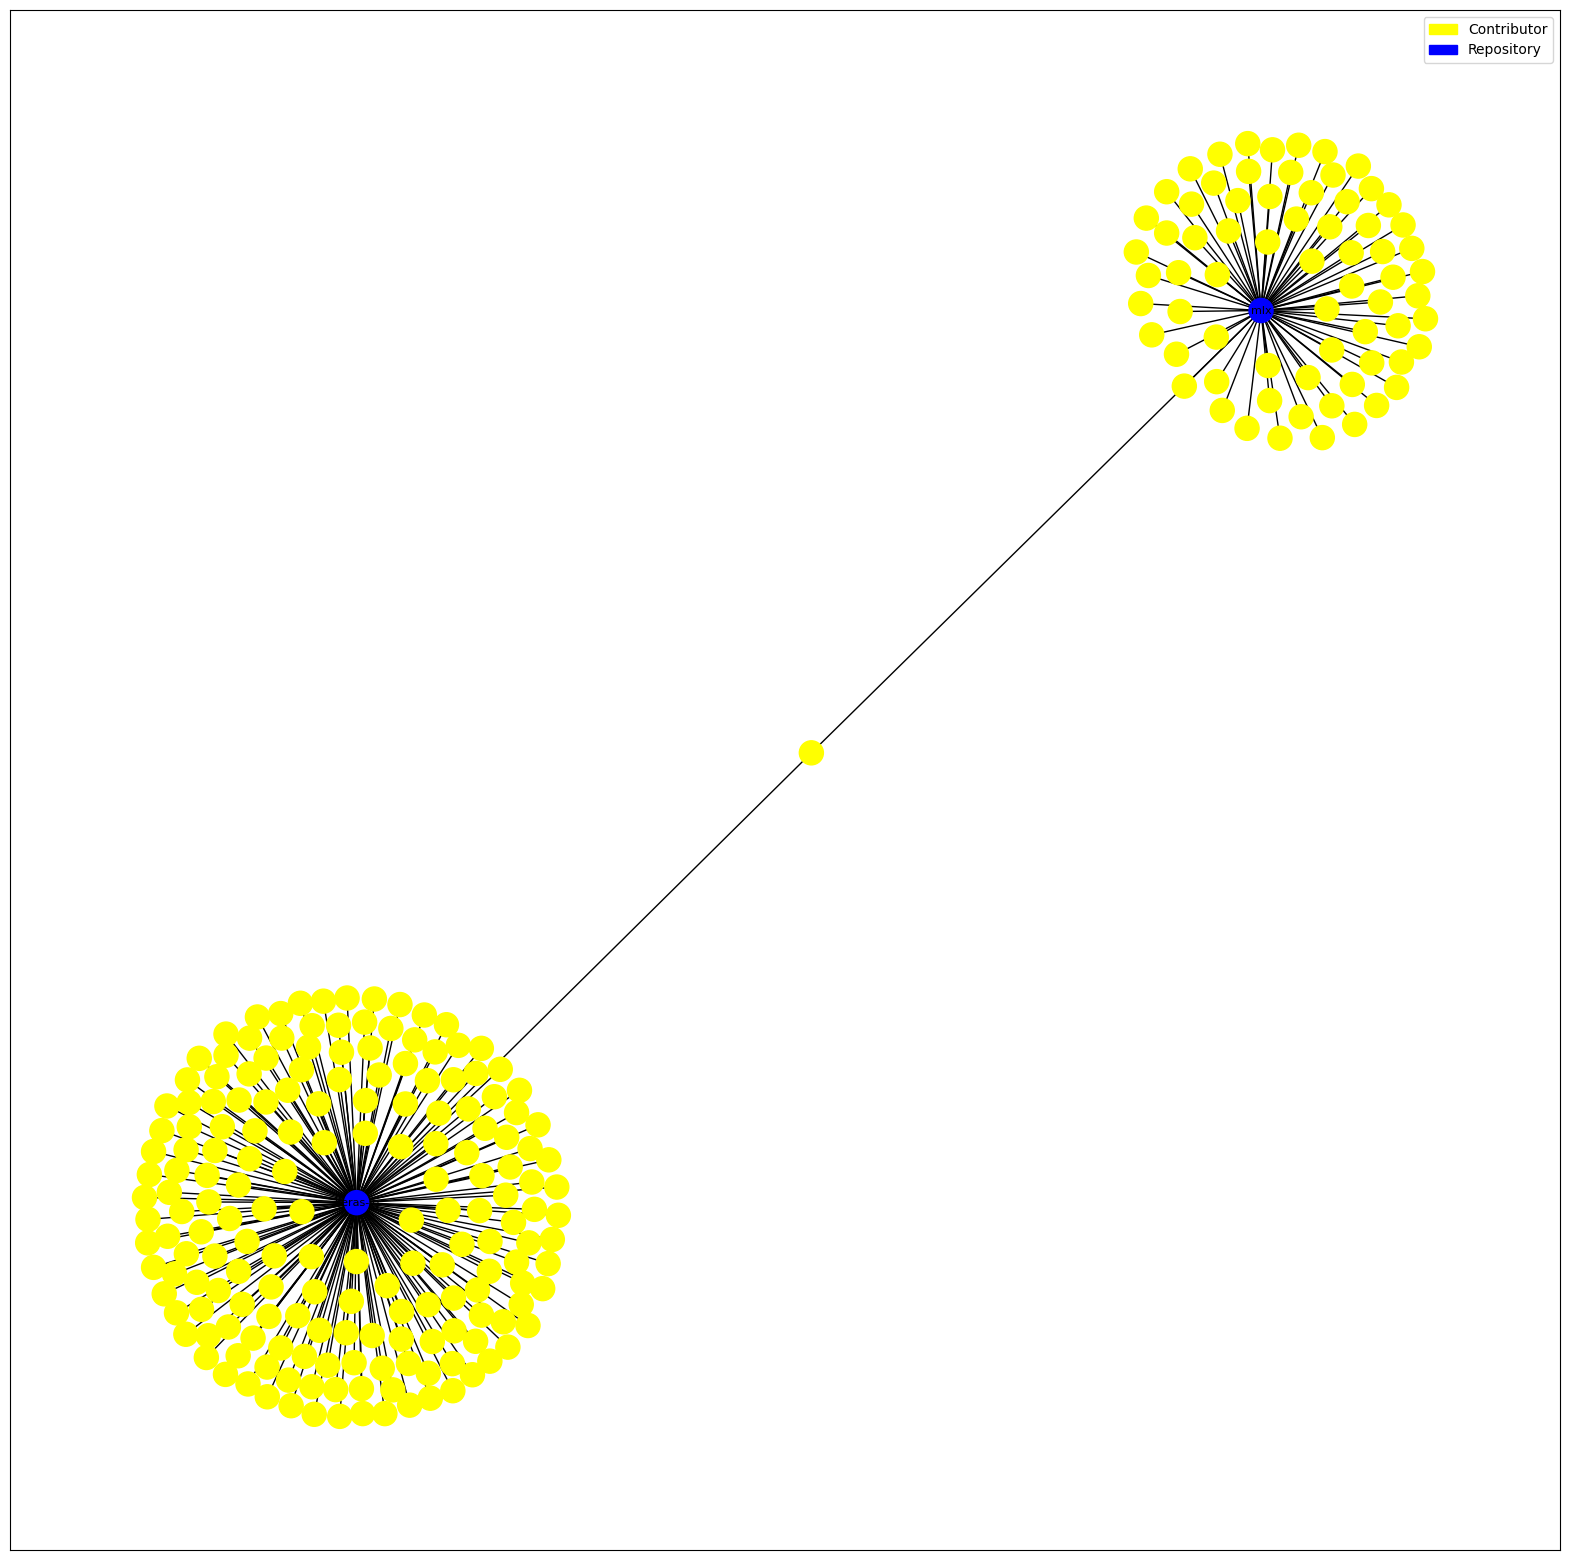

In [37]:
G = get_graph(df_melted_prr, source="repo_name", target='cntrb_id')
nodes = get_nodes(G)
colors = get_colors(nodes)
repo_labels = get_repo_labels(nodes)
plot(G, colors, repo_labels)

## Representing projects as nodes and edges as contributors

In this section, we represent data in a different way and try out another graph representation where the project repositories are represented by nodes and the edges are shared contributions(common conteributors contributing to different projects) between those projects

Lets pick the **Pull Request** type contribution for these graph plots as an example

In [38]:
df_melted_pr.head()

,repo_name,cntrb_id,number
8,tensorflow,01000000-5000-0000-0000-000000000000,3
10,arrow,01000002-3300-0000-0000-000000000000,53
28,tensorflow,01000002-5600-0000-0000-000000000000,3
35,pandas,01000002-8100-0000-0000-000000000000,2
48,tensorflow,01000004-6200-0000-0000-000000000000,1


`contributorGraph` is a dictionary where each key is a project repository, and the value is a list of **"connected"** project repositories and the number of **"shared connections"** between them. Lets explain **"connected"** repositories and shared "connections".

structure of `contributorGraph` =  
{  
`repo1`: [(`repo2`, `PRs by same authors in repo 1 and repo 2`)],  
 `repo2`: [(`repo4`, `PRs created by same authors in repo 1 and repo 4` ), (`repo5`, `PRs by same authors in repo 2 and repo 5`)]  
}

**"shared connections"** constitute of *commits*, *pull requests*, *issues* and *pull request reviews* that are made by the same contributor.
We will call 2 project repositories **"connected"** if they have a **"shared connection"** between them. 
This means if they have a contributor who makes a *commit*, *pull request*, *issue* or *pull request review* in both the repositories, they count as a shared contributor and the repositories are connected. 

We track the number of shared contributions between 2 repositories for creating this graph plot.

In [39]:
# Initialize an empty dictionary to store the graph
contributorGraph = {}

# Iterate over each row in df_melted_pr
for i, row in df_melted_pr.iterrows():
    # If the 'cntrb_id' is not already a key in the dictionary, add it with an empty list
    if row['cntrb_id'] not in contributorGraph:
        contributorGraph[row['cntrb_id']] = []
    
    # If 'number' is greater than 0, append a tuple of (repo_name, number) to the list for this 'cntrb_id'
    if row['number'] > 0:
        contributorGraph[row['cntrb_id']].append((row['repo_name'], row['number']))

In [40]:
# Initialize a defaultdict to store the sum of contributions for each pair of repositories
commonRepoContributionsByContributor = collections.defaultdict(int)

# Iterate over each contributor in the contributorGraph
for key in contributorGraph:
    # Skip contributors with less than 2 repositories in their list
    if len(contributorGraph[key])-1 <= 0:
        continue
    
    # Iterate through the list of repositories for the current contributor
    for repoContributionIndex in range(len(contributorGraph[key])-1):
        # Update the contribution sum for the pair of repositories
        commonRepoContributionsByContributor[
            (contributorGraph[key][repoContributionIndex][0], 
             contributorGraph[key][repoContributionIndex+1][0])
        ] += (contributorGraph[key][repoContributionIndex][1] + 
              contributorGraph[key][repoContributionIndex+1][1])

# Print the items of the commonRepoContributionsByContributor dictionary
print(commonRepoContributionsByContributor.items())

dict_items([(('pytorch', 'tensorflow'), 7902), (('arrow', 'pandas'), 8120), (('pandas', 'pytorch'), 2092), (('pytorch', 'tinygrad'), 161), (('tensorflow', 'tinygrad'), 854), (('arrow', 'pytorch'), 608), (('numpy', 'pandas'), 15707), (('pandas', 'tensorflow'), 1200), (('keras-io', 'tensorflow'), 528), (('networkx', 'numpy'), 2129), (('arrow', 'tensorflow'), 171), (('networkx', 'tensorflow'), 49), (('networkx', 'pandas'), 486), (('arrow', 'networkx'), 81), (('pandas', 'tinygrad'), 33), (('numpy', 'tensorflow'), 653), (('arrow', 'numpy'), 3517), (('numpy', 'pytorch'), 3956), (('mlx', 'pandas'), 6), (('mlx', 'tensorflow'), 38), (('keras-io', 'pandas'), 65), (('arrow', 'mlx'), 40), (('mlx', 'pytorch'), 39), (('keras-io', 'pytorch'), 74), (('networkx', 'tinygrad'), 17), (('arrow', 'keras-io'), 2), (('arrow', 'tinygrad'), 24), (('networkx', 'pytorch'), 75), (('mlx', 'tinygrad'), 101), (('mlx', 'networkx'), 2), (('keras-io', 'numpy'), 31), (('mlx', 'numpy'), 24), (('keras-io', 'networkx'), 2),

`commonRepoContributionsByContributor` is a nested dictionary consisting of dictionaries of repository pairs and their common contributions. 

structure of `commonRepoContributionsByContributor` =  
{  
(`repo1, repo2`): `PRs by same authors in repo 1 and repo 2`,  
(`repo2, repo4`): `PRs by same authors in repo 2 and repo 4`,  
(`repo2, repo5`): `PRs by same authors in repo 2 and repo 5`,   
}

In [41]:
# Initialize an empty list to store the results
res = []

# Iterate over each key-value pair in commonRepoContributionsByContributor
for key in commonRepoContributionsByContributor:
    # Convert the key (a tuple of repository names) to strings and append the corresponding value
    res.append(
        tuple(str(k) for k in list(key)) + (commonRepoContributionsByContributor[key],)
    )

In [42]:
res

[('pytorch', 'tensorflow', 7902),
 ('arrow', 'pandas', 8120),
 ('pandas', 'pytorch', 2092),
 ('pytorch', 'tinygrad', 161),
 ('tensorflow', 'tinygrad', 854),
 ('arrow', 'pytorch', 608),
 ('numpy', 'pandas', 15707),
 ('pandas', 'tensorflow', 1200),
 ('keras-io', 'tensorflow', 528),
 ('networkx', 'numpy', 2129),
 ('arrow', 'tensorflow', 171),
 ('networkx', 'tensorflow', 49),
 ('networkx', 'pandas', 486),
 ('arrow', 'networkx', 81),
 ('pandas', 'tinygrad', 33),
 ('numpy', 'tensorflow', 653),
 ('arrow', 'numpy', 3517),
 ('numpy', 'pytorch', 3956),
 ('mlx', 'pandas', 6),
 ('mlx', 'tensorflow', 38),
 ('keras-io', 'pandas', 65),
 ('arrow', 'mlx', 40),
 ('mlx', 'pytorch', 39),
 ('keras-io', 'pytorch', 74),
 ('networkx', 'tinygrad', 17),
 ('arrow', 'keras-io', 2),
 ('arrow', 'tinygrad', 24),
 ('networkx', 'pytorch', 75),
 ('mlx', 'tinygrad', 101),
 ('mlx', 'networkx', 2),
 ('keras-io', 'numpy', 31),
 ('mlx', 'numpy', 24),
 ('keras-io', 'networkx', 2),
 ('keras-io', 'mlx', 13),
 ('keras-io', 'tin

For plotting the graph below, we pick the repositories as the nodes and let the shared contributions dictate the edge weights

In [43]:
# Create an empty undirected graph
g = nx.Graph()

# Add edges with weights to the graph from the 'res' list
# Each item in 'res' should be a tuple in the format (node1, node2, weight)
g.add_weighted_edges_from(res)

The graph represents project repositories and how close or far they are to each other based on their degree of connected (number of shared contributions amongst them). If two nodes are close to each other, the two projects have a high number of shared contributions and vice versa. Each node in this graph has atleast one connection. We are not plotting lone projects in this graph as we want to identify project repositories in connection to existing known repositories.  
Note: this is not a complete (fully-connected) graph. All projects are not **"connected"** to each project. 

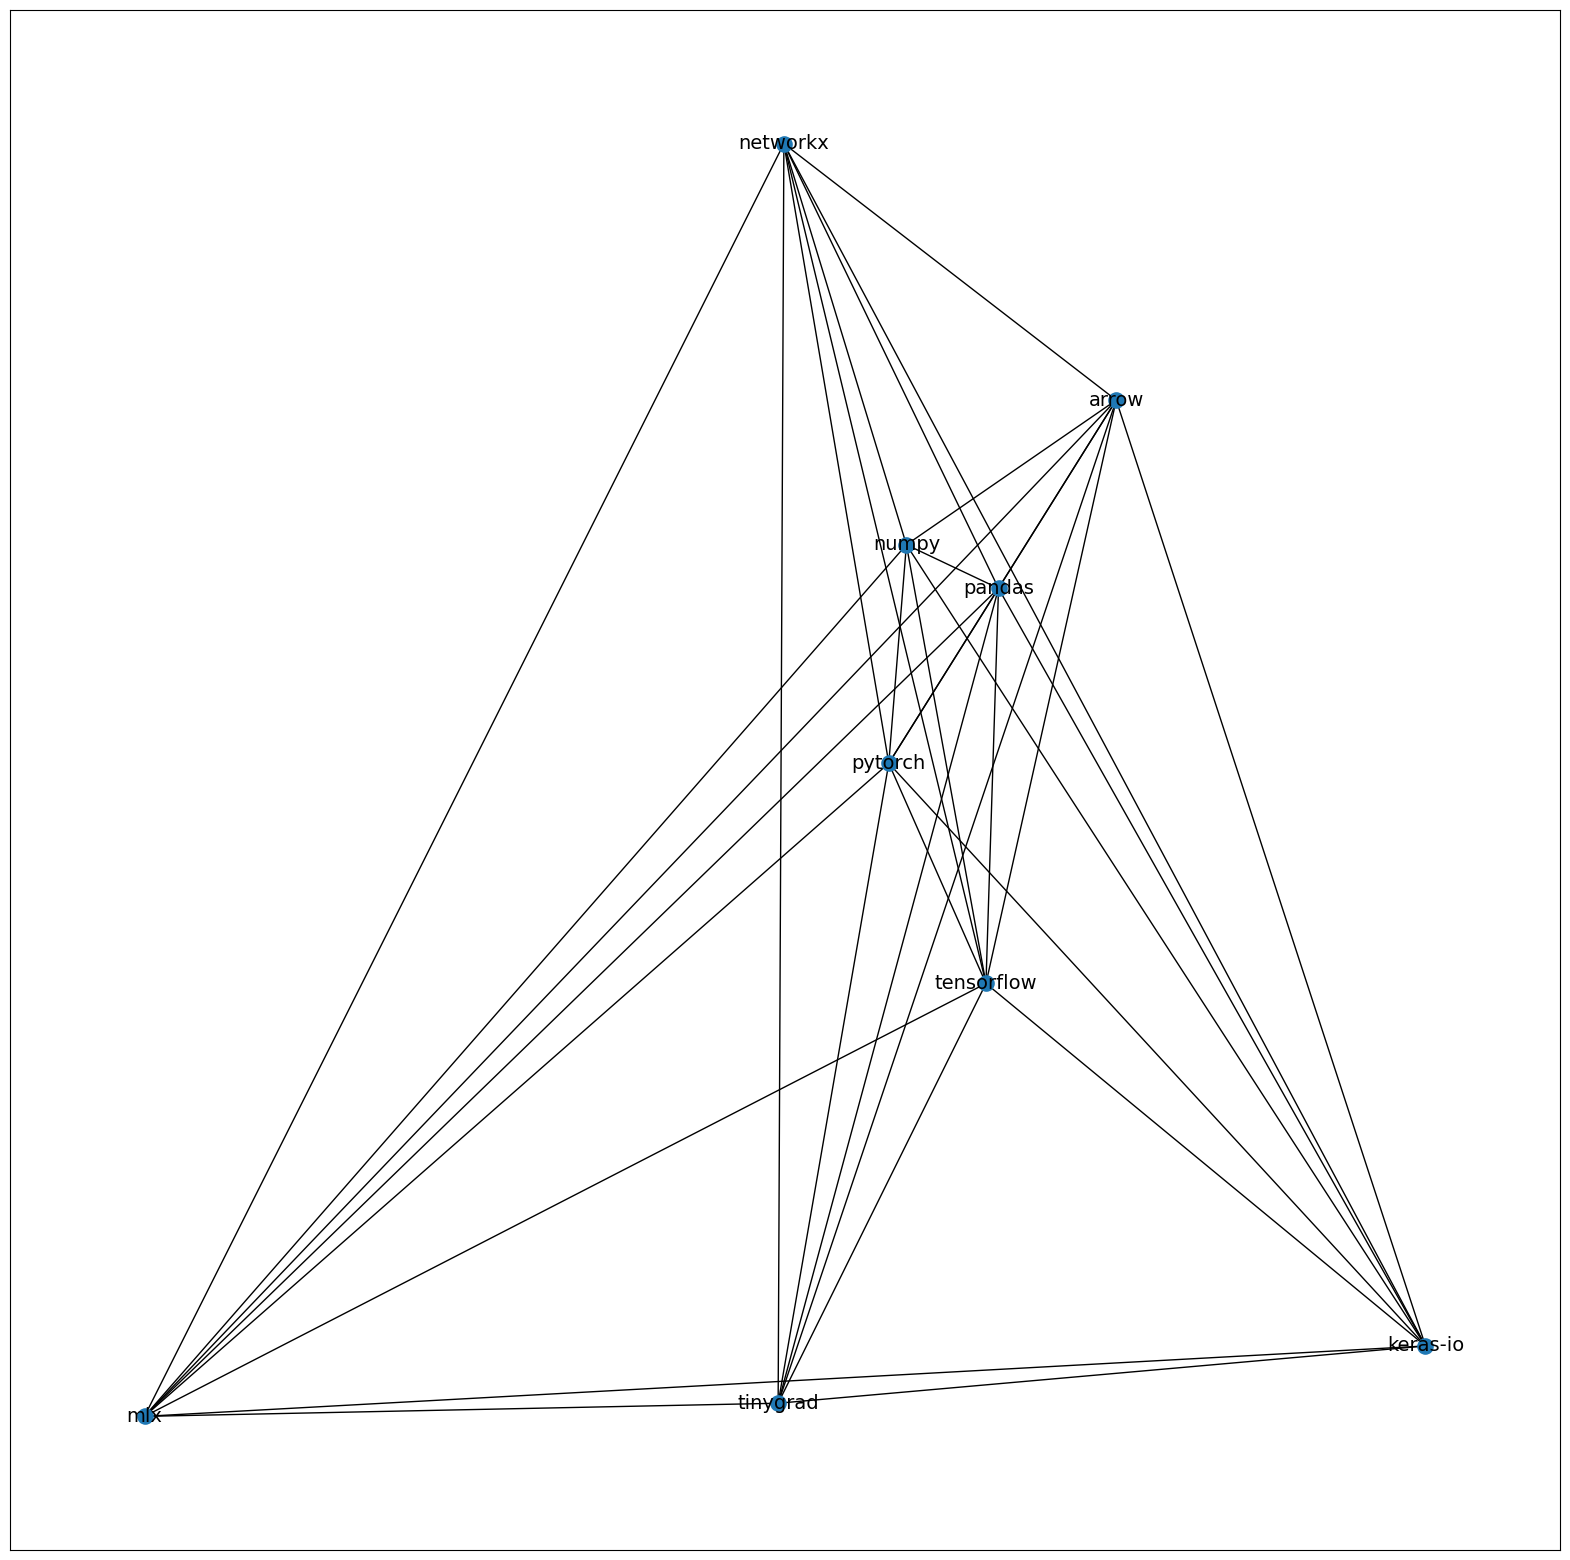

In [44]:
# Create a figure and axis for the plot with specified size
fig, ax = plt.subplots(figsize=(20, 20))

# Draw the graph on the axis with specified node size and font size
nx.draw_networkx(g, node_size=120, font_size=14, ax=ax)

## Conclusion

In this notebook, we created initial graph representations of existing open source GitHub repositories falling under a certain category using [NetworkX](https://networkx.org/). 

We used 2 type of graph representations:

- One where repositories and contributors both are both nodes (differently colored). Viewing which repositories share which set of contributors and analyzing their clusters can give an idea about how projects are connected to each other and to what degree 
- One where repositories are nodes, and edges are number of contributions. The distance between repositories, how close or far they are will depend on the number of shared contributions that exist between them.

In [45]:
# Record the current time as the end time
end_time = time.time()

# Calculate the elapsed time by subtracting start_time from end_time
elapsed_time = end_time - start_time

# Print the total execution time formatted to 2 decimal places
print(f'Total execution time: {elapsed_time:.2f} seconds')

Total execution time: 450.70 seconds
